In [3]:
import pandas as pd
import numpy as np
import spacy
import nltk
from ast import literal_eval
from HanTa import HanoverTagger as ht
import string
from tqdm.auto import tqdm
from collections import Counter
import top2vec
import torch
from itertools import chain
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tqdm.pandas()

# Experiment on the ZEIT dataset for all methodology steps
## Tokenize, remove punctuation & lower casing
First, the original scraped text file is loaded (note: I use gzip compression due to the big size of the files). I then get the column names of all 'comment' columns and use this to tokenize and clean all columns. The resulting tokenized & cleaned dataframe is saved with the ending '_preprocessed'.

In [16]:
# load csv of file to process
zeit = pd.read_csv('../data/zeit_scraped.gzip', compression='gzip', low_memory=False)

In [10]:
comment_cols = [col for col in zeit.columns if 'Comment' in col]

NameError: name 'zeit' is not defined

In [10]:
for cols in tqdm.tqdm(comment_cols):
    zeit[str(cols)] = zeit[str(cols)].fillna("").map(nltk.word_tokenize)

100%|██████████| 10612/10612 [28:25<00:00,  6.22it/s] 


In [ ]:
def remove_punctuation(text):
    text_list = []
    for word in text:
        for punctuation in string.punctuation:
            word = word.replace(punctuation, '')
        if not word:
            continue
        text_list.append(word.lower())
    return text_list

for cols in tqdm.tqdm(comment_cols):
    zeit[str(cols)] = zeit[str(cols)].apply(remove_punctuation)

In [15]:
# save csv file preprocessed
zeit.to_csv('../data/zeit_preprocessed.gzip', compression='gzip', index=False)

## Stop word removal, lemmatization of comments & emotion lexicon
Following, stopwords without meaning ('der', 'wo', etc.) are removed from the comments. I edited the sourced stopwords list and removed any negations, since these contain emotions that I want to capture later in the workflow. Afterwards, the remaining tokenized words for each comment are lemmatized, i.e. reduced to their basic form. In order to do this I utilise the 'Hannover Tagger', which also provides part of speech information, although I do not use it (the main reason that I do not use the PoS information is that the utilised German emotion and sentiment lexical use different PoS abbreviations, resulting in no matches). The resulting output is saved as a new file with the ending '_lemma'.

In [80]:
# load preprocessed file
zeit_pre = pd.read_csv('../data/zeit_preprocessed.gzip', compression='gzip', low_memory=False)

In [46]:
stopwords = open('../resources/german_stopwords-master/german_stopwords_plain.txt').read().splitlines()

In [47]:
def stop_word_removal(x):
    return list([w for w in literal_eval(x) if not w in stopwords])

In [48]:
for cols in tqdm.tqdm(comment_cols):
    zeit_pre[str(cols)] = zeit_pre[str(cols)].apply(stop_word_removal)

100%|██████████| 10612/10612 [1:07:22<00:00,  2.63it/s]  


In [11]:
tagger = ht.HanoverTagger('morphmodel_ger.pgz')

In [ ]:
def tagger_custom(input):
    tmp_list = []
    for word in input:
        tmp_list.append(tagger.analyze(word))
    return tmp_list

for cols in tqdm.tqdm(comment_cols):
    zeit_pre[str(cols)] = zeit_pre[str(cols)].apply(tagger_custom)

In [56]:
zeit_pre.to_csv('../data/zeit_lemma.gzip', compression='gzip', index=False)

#### Lemmatization of emotion lexicon
The utilised emotion lexicon by Robert Klinger is also lemmatized, in order to be able to match the lemmatized words in the comments to the ones in the lexicals. Note: I used an IF statement per lexicon since I did not manage to make it work in a combined FOR loop.

In [14]:
ekel = open('../resources/german-emotion-dictionary/Ekel.txt').read().splitlines()
freude = open('../resources/german-emotion-dictionary/Freude.txt').read().splitlines()
furcht = open('../resources/german-emotion-dictionary/Furcht.txt').read().splitlines()
trauer = open('../resources/german-emotion-dictionary/Trauer.txt').read().splitlines()
surprise = open('../resources/german-emotion-dictionary/Ueberraschung.txt').read().splitlines()
verachtung = open('../resources/german-emotion-dictionary/Verachtung.txt').read().splitlines()
wut = open('../resources/german-emotion-dictionary/Wut.txt').read().splitlines()

In [15]:
tmp_list = []
for words in ekel:
   tmp_list.append(tagger.analyze(words))
ekel = tmp_list
tmp_list = []
for emotion in ekel:
    x, y = emotion
    tmp_list.append(x.lower())
ekel = tmp_list

tmp_list = []
for words in freude:
    tmp_list.append(tagger.analyze(words))
freude = tmp_list
tmp_list = []
for emotion in freude:
    x, y = emotion
    tmp_list.append(x.lower())
freude = tmp_list

tmp_list = []
for words in furcht:
    tmp_list.append(tagger.analyze(words))
furcht = tmp_list
tmp_list = []
for emotion in furcht:
    x, y = emotion
    tmp_list.append(x.lower())
furcht = tmp_list

tmp_list = []
for words in trauer:
    tmp_list.append(tagger.analyze(words))
trauer = tmp_list
tmp_list = []
for emotion in trauer:
    x, y = emotion
    tmp_list.append(x.lower())
trauer = tmp_list

tmp_list = []
for words in surprise:
    tmp_list.append(tagger.analyze(words))
surprise = tmp_list
tmp_list = []
for emotion in surprise:
    x, y = emotion
    tmp_list.append(x.lower())
surprise = tmp_list

tmp_list = []
for words in verachtung:
    tmp_list.append(tagger.analyze(words))
verachtung = tmp_list
tmp_list = []
for emotion in verachtung:
    x, y = emotion
    tmp_list.append(x.lower())
verachtung = tmp_list

tmp_list = []
for words in wut:
    tmp_list.append(tagger.analyze(words))
wut = tmp_list
tmp_list = []
for emotion in wut:
    x, y = emotion
    tmp_list.append(x.lower())
wut = tmp_list

## Lexicon emotion classification (comments)
In this step, I assign every word in the tokenized and lemmatized comments to an emotion (if there is a match). Afterwards, for every comment the dominant emotion is detected and assigned as the overall emotion of the comment. This leaves me with one emotion per comment, which are added into one large list per news article. The resulting file is saved with the ending '_emo_clas'.

In [2]:
zeit_emo_clas = pd.read_csv('../data/zeit_lemma.gzip', compression='gzip', low_memory=False, index_col=0)

In [16]:
def emo_class(input):
    tmp_list = []
    for word in literal_eval(input):
        if not word:
            continue
        x, y  = word
        if str(x).lower() in ekel:
            tmp_list.append('ekel')
        if str(x).lower() in freude:
            tmp_list.append('freude')
        if str(x).lower() in furcht:
            tmp_list.append('furcht')
        if str(x).lower() in trauer:
            tmp_list.append('trauer')
        if str(x).lower() in surprise:
            tmp_list.append('surprise')
        if str(x).lower() in verachtung:
            tmp_list.append('verachtung')
        if str(x).lower() in wut:
            tmp_list.append('wut')
    if not tmp_list:
        return None
    return Counter(tmp_list).most_common(1)[0][0]

In [13]:
comment_cols = [col for col in zeit_emo_clas.columns if 'Comment' in col]

In [188]:
for cols in tqdm.tqdm(comment_cols):
    zeit_emo_clas[str(cols)] = zeit_emo_clas[str(cols)].apply(emo_class)

100%|██████████| 10612/10612 [59:59<00:00,  2.95it/s] 


In [191]:
zeit_emo_clas['combined_comments'] = [[y for y in x if pd.notna(y)] for x in zeit_emo_clas[comment_cols].values.tolist()]
zeit_emo_clas.drop(comment_cols, inplace=True, axis=1)

In [248]:
def gen_emo_clas(row):
    if not literal_eval(row['combined_comments']):
        return None
    else:
        return Counter(literal_eval(row['combined_comments'])).most_common(1)[0][0]

In [249]:
zeit_emo_clas['emotion_comments'] = zeit_emo_clas.apply(gen_emo_clas, axis=1)

In [251]:
zeit_emo_clas.to_csv('../data/zeit_emo_clas.gzip', compression='gzip', index=False)

## Sentiment classification with lexicon (comments)
Similar to the previous step, the comments are also assigned to negative or positive sentiment overall, in a similar fashion. The result is saved in a new file with the ending '_senti_clas'.

In [2]:
zeit_senti_clas = pd.read_csv('../data/zeit_lemma.gzip', compression='gzip', low_memory=False, index_col=0)

In [69]:
senti_merge = pd.read_csv('../resources/sentimerge/data/sentimerge.txt', sep='\t')
senti_merge.drop(['PoS'], axis=1, inplace=True)

In [70]:
senti_merge_pos = senti_merge.loc[senti_merge['sentiment'] > 0]
senti_merge_neg = senti_merge.loc[senti_merge['sentiment'] < 0]

In [71]:
senti_pos_dict = dict(zip(senti_merge_pos['lemma'], senti_merge_pos['sentiment']))
senti_neg_dict = dict(zip(senti_merge_neg['lemma'], senti_merge_neg['sentiment']))
senti_weight_dict = dict(zip(senti_merge['lemma'], senti_merge['weight']))

In [173]:
def senti_class(input):
    tmp_list = []
    for word in literal_eval(input):
        if not word:
            continue
        x, y  = word
        if str(x).lower() in senti_pos_dict:
            tmp_list.append((senti_pos_dict[x.lower()]*senti_weight_dict[x.lower()]))
        if str(x).lower() in senti_neg_dict:
            tmp_list.append((senti_neg_dict[x.lower()]*senti_weight_dict[x.lower()]))
    if not tmp_list:
        return np.nan
    return sum(tmp_list)

In [174]:
def rescale(input):
    tmp = input
    tmp -= tmp.min()
    tmp /= tmp.max()
    return tmp

In [175]:
def lexi_label(input):
    if input > 1:
        return 'positive'
    elif input < -1:
        return 'negative'
    elif pd.isna(input):
        return np.nan
    else:
        return 'neutral'

In [21]:
import plotly.express as px
fig = px.histogram(zeit_senti_clas, x="Comment0", nbins=1000)
fig.show()

In [ ]:
comment_cols = [col for col in zeit_senti_clas.columns if 'Comment' in col]
for cols in tqdm(comment_cols):
    tmp_lexi_scores = zeit_senti_clas[str(cols)].apply(senti_class)
    #zeit_senti_clas[str(cols+'_lscore')] = rescale(zeit_senti_clas[str(cols)].apply(senti_class))
    zeit_senti_clas[str(cols+'_llabel')] = tmp_lexi_scores.apply(lexi_label)
    zeit_senti_clas[str(cols+'_lscore')] = rescale(tmp_lexi_scores)

In [178]:
score_cols = [col for col in zeit_senti_clas.columns if 'lscore' in col]
zeit_senti_clas['lexi_scores'] = [[y for y in x if pd.notna(y)] for x in zeit_senti_clas[score_cols].values.tolist()]
zeit_senti_clas.drop(score_cols, inplace=True, axis=1)

In [179]:
label_cols = [col for col in zeit_senti_clas.columns if 'llabel' in col]
zeit_senti_clas['lexi_labels'] = [[y for y in x if pd.notna(y)] for x in zeit_senti_clas[label_cols].values.tolist()]
zeit_senti_clas.drop(label_cols, inplace=True, axis=1)

In [182]:
zeit_senti_clas.drop(comment_cols, inplace=True, axis=1)

### Add: add lexicon sentiment in numeric form and compare with BERT sentiment to get high confidence predictions before converting into pos/neg label

In [184]:
zeit_senti_clas.to_csv('../data/zeit_senti_clas.gzip', compression='gzip', index=False)

## Sentiment classification with BERT (comments)

In [4]:
zeit = pd.read_csv('../data/zeit_scraped.gzip', compression='gzip', low_memory=False)

In [5]:
zeit

,title,link,date,combined_text,Tag0,Tag1,Tag2,Tag3,Tag4,Tag5,...,Comment10602,Comment10603,Comment10604,Comment10605,Comment10606,Comment10607,Comment10608,Comment10609,Comment10610,Comment10611
0,"Handel: ""Viele brauchen ja eigentlich nichts m...",https://www.zeit.de/2021/48/handel-adventszeit...,2021-11-30 06:07:00,"ZEIT: Herr Weber, Herr Rauschen, Herr Greiner,...",Advent,Einzelhandel,Pandemie,KaDeWe,Karstadt,Corona,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DGB-Index Gute Arbeit: An den Kosten im Homeof...,https://www.zeit.de/wirtschaft/2021-11/dgb-ind...,2021-11-30 05:50:00,Wie gut sind die Arbeitsbedingungen in Deutsch...,DGB,Studie,Home Office,Corona,Digitalisierung,Alle Themen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Coronavirus: RKI registriert erstmals wieder l...,https://www.zeit.de/gesundheit/2021-11/coronav...,2021-11-30 04:23:00,Die Zahl der Neuinfektionen pro 100.000 \nEinw...,Coronavirus,Neuinfektion,RKI,Sachsen,Thüringen,Brandenburg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bund-Länder-Runde: Kanzleramtschef fordert Cor...,https://www.zeit.de/politik/deutschland/2021-1...,2021-11-30 02:01:00,Vor der Bund-Länder-Schalte zur Corona-Krise\n...,Coronavirus,Neuinfektion,Maskenpflicht,Stadion,Helge Braun,Olaf Scholz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Corona-Impfung für Kinder: Gesundheitsminister...,https://www.zeit.de/gesundheit/2021-11/corona-...,2021-11-29 19:22:00,Die Gesundheitsministerinnen und -minister der...,Corona,Impfstoff,Coronavirus,Corona-Impfung,Impfung,Alle Themen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8663,Malaysia: Squash-WM der Männer abgesagt,https://www.zeit.de/sport/2021-11/squash-wm-ab...,2021-11-30 12:11:00,Die Squashweltmeisterschaft der Männer in Mala...,Israel,Malaysia,Diskriminierung,Leistungssport,Coronavirus,Omikron,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8664,Corona-Impfstoff: Moderna rechnet mit geringer...,https://www.zeit.de/gesundheit/2021-11/corona-...,2021-11-30 11:52:00,"Der Chef des US-Pharmakonzerns Moderna, Stépha...",Omikron,Impfstoff,Delta-Variante,Corona-Impfung,Coronavirus,Pharmaindustrie,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8665,Bundesverfassungsgericht: Corona-Ausgangsbesch...,https://www.zeit.de/politik/deutschland/2021-1...,2021-11-30 10:42:00,Die im April 2021\nbeschlossene Bundesnotbrems...,Coronavirus,Verfassungsgericht,Grundgesetz,Corona-Maßnahmen,Justiz,Bundesregierung,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8666,Koalitionsvertrag: Ein Dokument voller schille...,https://www.zeit.de/politik/deutschland/2021-1...,2021-11-30 07:27:00,"Es\nist schon eine ungewöhnliche, unverständli...",Koalitionsvertrag,Corona-Maßnahmen,Umweltschutz,SPD,FDP,Bündnis 90/Die Grünen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
comment_cols = [col for col in zeit.columns if 'Comment' in col]

In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from typing import List
import torch
import re

class SentimentModel():
    def __init__(self, model_name: str):
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.clean_chars = re.compile(r'[^A-Za-züöäÖÜÄß ]', re.MULTILINE)
        self.clean_http_urls = re.compile(r'https*\\S+', re.MULTILINE)
        self.clean_at_mentions = re.compile(r'@\\S+', re.MULTILINE)

    def predict_sentiment(self, texts):
        if np.any(pd.isna(texts)):
          return np.nan
        texts = [self.clean_text(str(text)) for text in [texts]]
        # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model.
        encoded = self.tokenizer.batch_encode_plus(texts,padding=True, add_special_tokens=True,truncation=True, return_tensors="pt")
        encoded = encoded.to(self.device)
        with torch.no_grad():
                logits = self.model(**encoded)

        label_ids = torch.argmax(logits[0], axis=1)
        for a in zip(logits[0].tolist(), [self.model.config.id2label[label_id] for label_id in label_ids.tolist()]):
            tmp_rsl = list(a)
        return tmp_rsl

    def replace_numbers(self,text: str) -> str:
            return text.replace("0"," null").replace("1"," eins").replace("2"," zwei").replace("3"," drei").replace("4"," vier").replace("5"," fünf").replace("6"," sechs").replace("7"," sieben").replace("8"," acht").replace("9"," neun")

    def clean_text(self,text: str)-> str:
            text = text.replace("\n", " ")
            text = self.clean_http_urls.sub('',text)
            text = self.clean_at_mentions.sub('',text)
            text = self.replace_numbers(text)
            text = self.clean_chars.sub('', text) # use only text chars
            text = ' '.join(text.split()) # substitute multiple whitespace with single whitespace
            text = text.strip().lower()
            return text

In [9]:
model = SentimentModel(model_name = "oliverguhr/german-sentiment-bert")

In [23]:
for cols in tqdm(comment_cols[2130:2136]):
    tmp_list = []
    for chunk in tqdm(np.array_split(zeit[str(cols)], 100)):
        tmp_list.append(chunk.apply(model.predict_sentiment))
    result = list(chain.from_iterable(tmp_list))
    tmp_score = []
    tmp_label = []
    for record in result:
        if np.any(pd.isna(record)):
            tmp_score.append(np.nan)
            tmp_label.append(np.nan)
            continue
        tmp_score.append(np.ptp(sorted(list(map(abs, record[0])))))
        tmp_label.append(record[1])
    tmp_frame = pd.DataFrame()
    tmp_frame['score'] = tmp_score
    tmp_frame['label'] = tmp_label
    tmp_frame['score'] -= tmp_frame['score'].min()
    tmp_frame['score'] /= tmp_frame['score'].max()
    zeit[str(cols)+'_bscore'] = tmp_frame['score']
    zeit[str(cols)+'_blabel'] = tmp_frame['label']
    zeit.drop(cols, inplace=True, axis=1)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
for cols in tqdm(comment_cols[2123:2127]):
    tmp_list = []
    for chunk in tqdm(np.array_split(zeit[str(cols)], 100)):
        tmp_list.append(chunk.apply(model.predict_sentiment))
    result = list(chain.from_iterable(tmp_list))
    tmp_score = []
    tmp_label = []
    for record in result:
        if np.any(pd.isna(record)):
            tmp_score.append(np.nan)
            tmp_label.append(np.nan)
            continue
        tmp_score.append(np.ptp(sorted(list(map(abs, record[0])))))
        tmp_label.append(record[1])
    tmp_frame = pd.DataFrame()
    tmp_frame['score'] = tmp_score
    tmp_frame['label'] = tmp_label
    tmp_frame['score'] -= tmp_frame['score'].min()
    tmp_frame['score'] /= tmp_frame['score'].max()
    zeit[str(cols)+'_bscore'] = tmp_frame['score']
    zeit[str(cols)+'_blabel'] = tmp_frame['label']
    zeit.drop(cols, inplace=True, axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [255]:
zeit

,title,link,date,combined_text,Tag0,Tag1,Tag2,Tag3,Tag4,Tag5,...,Comment131_bscore,Comment131_blabel,Comment140_bscore,Comment140_blabel,Comment141_bscore,Comment141_blabel,Comment0_bscore,Comment0_blabel,Comment1_bscore,Comment1_blabel
0,"Handel: ""Viele brauchen ja eigentlich nichts m...",https://www.zeit.de/2021/48/handel-adventszeit...,2021-11-30 06:07:00,"ZEIT: Herr Weber, Herr Rauschen, Herr Greiner,...",Advent,Einzelhandel,Pandemie,KaDeWe,Karstadt,Corona,...,NaN,NaN,NaN,NaN,NaN,NaN,0.207426,neutral,0.228576,neutral
1,DGB-Index Gute Arbeit: An den Kosten im Homeof...,https://www.zeit.de/wirtschaft/2021-11/dgb-ind...,2021-11-30 05:50:00,Wie gut sind die Arbeitsbedingungen in Deutsch...,DGB,Studie,Home Office,Corona,Digitalisierung,Alle Themen,...,NaN,NaN,NaN,NaN,NaN,NaN,0.422796,positive,0.696672,negative
2,Coronavirus: RKI registriert erstmals wieder l...,https://www.zeit.de/gesundheit/2021-11/coronav...,2021-11-30 04:23:00,Die Zahl der Neuinfektionen pro 100.000 \nEinw...,Coronavirus,Neuinfektion,RKI,Sachsen,Thüringen,Brandenburg,...,NaN,NaN,NaN,NaN,NaN,NaN,0.603117,positive,0.296333,neutral
3,Bund-Länder-Runde: Kanzleramtschef fordert Cor...,https://www.zeit.de/politik/deutschland/2021-1...,2021-11-30 02:01:00,Vor der Bund-Länder-Schalte zur Corona-Krise\n...,Coronavirus,Neuinfektion,Maskenpflicht,Stadion,Helge Braun,Olaf Scholz,...,NaN,NaN,NaN,NaN,NaN,NaN,0.344321,negative,0.336201,negative
4,Corona-Impfung für Kinder: Gesundheitsminister...,https://www.zeit.de/gesundheit/2021-11/corona-...,2021-11-29 19:22:00,Die Gesundheitsministerinnen und -minister der...,Corona,Impfstoff,Coronavirus,Corona-Impfung,Impfung,Alle Themen,...,NaN,NaN,NaN,NaN,NaN,NaN,0.425351,negative,0.542338,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8663,Malaysia: Squash-WM der Männer abgesagt,https://www.zeit.de/sport/2021-11/squash-wm-ab...,2021-11-30 12:11:00,Die Squashweltmeisterschaft der Männer in Mala...,Israel,Malaysia,Diskriminierung,Leistungssport,Coronavirus,Omikron,...,NaN,NaN,NaN,NaN,NaN,NaN,0.339469,positive,0.150747,neutral
8664,Corona-Impfstoff: Moderna rechnet mit geringer...,https://www.zeit.de/gesundheit/2021-11/corona-...,2021-11-30 11:52:00,"Der Chef des US-Pharmakonzerns Moderna, Stépha...",Omikron,Impfstoff,Delta-Variante,Corona-Impfung,Coronavirus,Pharmaindustrie,...,NaN,NaN,NaN,NaN,NaN,NaN,0.509743,neutral,0.292503,negative
8665,Bundesverfassungsgericht: Corona-Ausgangsbesch...,https://www.zeit.de/politik/deutschland/2021-1...,2021-11-30 10:42:00,Die im April 2021\nbeschlossene Bundesnotbrems...,Coronavirus,Verfassungsgericht,Grundgesetz,Corona-Maßnahmen,Justiz,Bundesregierung,...,NaN,negative,0.533418,neutral,0.090175,negative,0.255843,positive,0.457939,neutral
8666,Koalitionsvertrag: Ein Dokument voller schille...,https://www.zeit.de/politik/deutschland/2021-1...,2021-11-30 07:27:00,"Es\nist schon eine ungewöhnliche, unverständli...",Koalitionsvertrag,Corona-Maßnahmen,Umweltschutz,SPD,FDP,Bündnis 90/Die Grünen,...,NaN,NaN,NaN,NaN,NaN,NaN,0.255272,negative,0.570911,neutral


In [26]:
zeit_senti_clas_bert = pd.read_csv('../data/zeit_senti_clas_bert.gzip', compression='gzip', low_memory=False)

In [28]:
zeit_senti_clas_bert['Comment204_blabel']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
8663        NaN
8664        NaN
8665    neutral
8666        NaN
8667        NaN
Name: Comment204_blabel, Length: 8668, dtype: object

## Topic modeling with top2vec for articles
Creates unique topics for each article, as feature for the comment prediction. Has to be run with speed='learn' / 'deep-learn' properly.

In [2]:
zeit_pre = pd.read_csv('../data/zeit_preprocessed.gzip', compression='gzip', low_memory=False)

In [4]:
model = top2vec.Top2Vec(list(zeit_pre['combined_text']), min_count=50, speed="fast-learn", ngram_vocab=True, workers=18)

2022-04-15 10:54:17,124 - top2vec - INFO - Pre-processing documents for training
2022-04-15 10:54:29,526 - top2vec - INFO - Creating joint document/word embedding
2022-04-15 11:01:40,566 - top2vec - INFO - Creating lower dimension embedding of documents
2022-04-15 11:01:52,352 - top2vec - INFO - Finding dense areas of documents
2022-04-15 11:01:52,503 - top2vec - INFO - Finding topics


In [15]:
red_topics = model.hierarchical_topic_reduction(10)

In [16]:
topic_nums, topic_score, topics_words, word_scores = model.get_documents_topics(list(zeit_pre.index), reduced=True)

In [21]:
topic_words, word_scores, topic_nums = model.get_topics(10, reduced=True)

In [22]:
topic_words

array([['paar wochen', 'gar nichts', 'alles vorbei', 'noch einmal',
        'erst mal', 'etwas abgewinnen', 'paar jahre', 'dieses mal',
        'bewege mich', 'ein paar', 'einigte man', 'fast jeden',
        'viele leute', 'wundere mich', 'mein leben', 'sehr viel',
        'alles zusammenbricht', 'manchmal sogar', 'ich weiß',
        'uberhaupt nichts', 'kaum etwas', 'paar jahren', 'ihr leben',
        'einen stift', 'diesem moment', 'nichts anhaben', 'nichts boses',
        'paar tage', 'mehr zulauf', 'niemand weiß', 'ganz sicher',
        'ihr bisheriger', 'noch nie', 'endlich mal', 'etwas sinnvolles',
        'mein mann', 'alles andere', 'seht ihr', 'appelliere an',
        'vielleicht sogar', 'schame mich', 'hor mal', 'investiere ich',
        'meine masterarbeit', 'paar stunden', 'etwas erstaunliches',
        'gar nicht', 'ein brennglas', 'ich habe', 'weiß niemand'],
       ['weitere menschen', 'tagen ab', 'in deutschland', 'sieben tagen',
        'laut robert', 'des flughafens',

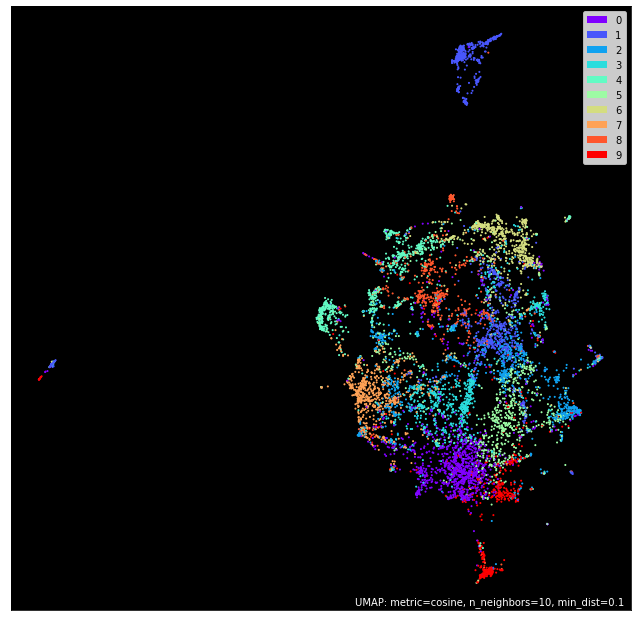

In [25]:
import umap.plot
umap_args_model = {
"n_neighbors": 10,
"n_components": 2,
"metric": "cosine",
'min_dist':0.10,
'spread':1
}
umap_model = umap.UMAP(**umap_args_model).fit(model.document_vectors)
umap_fig2 = umap.plot.points(umap_model, labels = model.doc_top_reduced, theme='fire')

## Construct prediction dataset

In [255]:
zeit_pred = zeit_senti_clas[['title', 'date', 'combined_text', 'sentiment_commments']]

In [258]:
zeit_pred['emotion_comments'] = zeit_emo_clas['emotion_comments']

/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_71582/2905082200.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zeit_pred['emotion_comments'] = zeit_emo_clas['emotion_comments']


In [259]:
zeit_pred

,title,date,combined_text,sentiment_commments,emotion_comments
0,"Handel: ""Viele brauchen ja eigentlich nichts m...",2021-11-30 06:07:00,"ZEIT: Herr Weber, Herr Rauschen, Herr Greiner,...",neutral,freude
1,DGB-Index Gute Arbeit: An den Kosten im Homeof...,2021-11-30 05:50:00,Wie gut sind die Arbeitsbedingungen in Deutsch...,positive,freude
2,Coronavirus: RKI registriert erstmals wieder l...,2021-11-30 04:23:00,Die Zahl der Neuinfektionen pro 100.000 \nEinw...,negative,freude
3,Bund-Länder-Runde: Kanzleramtschef fordert Cor...,2021-11-30 02:01:00,Vor der Bund-Länder-Schalte zur Corona-Krise\n...,negative,verachtung
4,Corona-Impfung für Kinder: Gesundheitsminister...,2021-11-29 19:22:00,Die Gesundheitsministerinnen und -minister der...,negative,verachtung
...,...,...,...,...,...
8663,Malaysia: Squash-WM der Männer abgesagt,2021-11-30 12:11:00,Die Squashweltmeisterschaft der Männer in Mala...,neutral,freude
8664,Corona-Impfstoff: Moderna rechnet mit geringer...,2021-11-30 11:52:00,"Der Chef des US-Pharmakonzerns Moderna, Stépha...",neutral,surprise
8665,Bundesverfassungsgericht: Corona-Ausgangsbesch...,2021-11-30 10:42:00,Die im April 2021\nbeschlossene Bundesnotbrems...,negative,verachtung
8666,Koalitionsvertrag: Ein Dokument voller schille...,2021-11-30 07:27:00,"Es\nist schon eine ungewöhnliche, unverständli...",neutral,freude


# Translate texts to english using Helsinki NLP Bert model to leverage english emotion classification methods

In [7]:
from pygoogletranslation import Translator
translator = Translator()
comments['translated'] = ""

In [8]:
result = translator.translate(list(comments['Comment0'][0:1000]), src='de', dest='en')

In [13]:
for idx, t in tqdm.tqdm(enumerate(result)):
    comments['translated'][idx] = t.text

1000it [00:00, 17145.29it/s]


In [4]:
#comments.to_csv('../data/english_comments.csv')

In [ ]:
from transformers import *

In [ ]:
# source & destination languages
src = "de"
dst = "en"

task_name = f"translation_{src}_to_{dst}"
model_name = f"Helsinki-NLP/opus-mt-{src}-{dst}"

translator  = pipeline(task_name, model=model_name, tokenizer=model_name)

In [7]:
%%time
translations = translator(list(comments['Comment0'][0:1000]))
comments['translated'] = ""
for idx, texts in enumerate(translations):
    comments['translated'][idx] = texts['translation_text']

Disabling tokenizer parallelism, we're using DataLoader multithreading already


CPU times: user 19min 39s, sys: 5min 37s, total: 25min 17s
Wall time: 23min 48s


# First try at emotion classification

### load example of German and English translated comments

In [35]:
comments = pd.read_csv('../data/english_comments.csv', index_col=0)

In [46]:
comments

,Comment0,translated,tokzenized_comment_GER,tokzenized_comment_ENG,lemmatized_hanta,lemmatized_spacy
0,"Sehr schönes Interview, Danke! Es ist eben ni...","Very nice interview, thanks!It's not just the ...","[Sehr, schönes, Interview, ,, Danke, !, Es, is...","[Very, nice, interview, ,, thanks, !, It, 's, ...","[(sehr, ADV), (schön, ADJA), (Interview, NN), ...","[(Very, NE), (Nice, NE), (Interview, NN), (--,..."
1,Home Office wo und wann immer möglich UND fal...,Home Office Where and whenever possible and if...,"[Home, Office, wo, und, wann, immer, möglich, ...","[Home, Office, Where, and, whenever, possible,...","[(home, FM), (Office, NE), (wo, PWAV), (und, K...","[(home, FM), (Office, NE), (Where, NN), (And, ..."
2,Wie ich es voraus gesagt habe. Es zeichnete s...,"How I told it.It was simple, the weekly increa...","[Wie, ich, es, voraus, gesagt, habe, ., Es, ze...","[How, I, told, it.It, was, simple, ,, the, wee...","[(wie, KOKOM), (ich, PPER), (es, PPER), (vorau...","[(how, FM), (i, CARD), (Told, NE), (It.it, NE)..."
3,Entfernt. Bitte verzichten Sie auf Unterstell...,Removed.Please refrain from undertakings.Thank...,"[Entfernt, ., Bitte, verzichten, Sie, auf, Unt...","[Removed.Please, refrain, from, undertakings.T...","[(Entfernt, NN), (--, $.), (bitte, ADV), (Verz...","[(Removed.please, NN), (Refrain, NE), (from, F..."
4,Warum schafft man eigentlich nicht endlich di...,Why do not you finally make the stiko?There is...,"[Warum, schafft, man, eigentlich, nicht, endli...","[Why, do, not, you, finally, make, the, stiko,...","[(warum, PWAV), (schaffen, VVFIN), (man, PIS),...","[(Why, NE), (Do, NE), (Not, NN), (you, FM), (F..."
...,...,...,...,...,...,...
8663,"Kompliment an die WSF, endlich mal eine Organ...",NaN,"[Kompliment, an, die, WSF, ,, endlich, mal, ei...",[nan],"[(Kompliment, NN), (an, APPR), (die, ART), (Ws...","[(Nan, NE)]"
8664,"Aha, nichts Genaues wissen alle Experten noch...",NaN,"[Aha, ,, nichts, Genaues, wissen, alle, Expert...",[nan],"[(Aha, NE), (--, $,), (nichts, PIS), (genau, A...","[(Nan, NE)]"
8665,Vielen Dank an das BVerfG.,NaN,"[Vielen, Dank, an, das, BVerfG, .]",[nan],"[(vielen, PIAT), (dank, APPR), (an, APPR), (da...","[(Nan, NE)]"
8666,Entfernt. Bitte verzichten Sie auf Spekulatio...,NaN,"[Entfernt, ., Bitte, verzichten, Sie, auf, Spe...",[nan],"[(Entfernt, NN), (--, $.), (bitte, ADV), (Verz...","[(Nan, NE)]"


### tokenize examples and remove unwanted characters

In [ ]:
tagger = ht.HanoverTagger('morphmodel_ger.pgz')
comments['tokzenized_comment_GER'] = ""
comments['tokzenized_comment_ENG'] = ""
comments['lemmatized_hanta'] = ""
comments['lemmatized_spacy'] = ""

In [ ]:
for idx, comment in enumerate(comments['Comment0']):
    comments['tokzenized_comment_GER'][idx] = nltk.tokenize.word_tokenize(str(comment), language='german',
                                                                          preserve_line=False)
for idx, comment in enumerate(comments['translated']):
    comments['tokzenized_comment_ENG'][idx] = nltk.tokenize.word_tokenize(str(comment), language='english',
                                                                          preserve_line=False)

In [ ]:
from transformers import pipeline
classifier = pipeline("text-classification",model='bhadresh-savani/bert-base-go-emotion', return_all_scores=True)

In [90]:
prediction = classifier(list(comments['translated'][0:10]), truncation = True)
print(prediction)

[[{'label': 'admiration', 'score': 0.0452674999833107}, {'label': 'amusement', 'score': 0.0013594082556664944}, {'label': 'anger', 'score': 0.0004618511302396655}, {'label': 'annoyance', 'score': 0.0018939633155241609}, {'label': 'approval', 'score': 0.019459852948784828}, {'label': 'caring', 'score': 0.008181571029126644}, {'label': 'confusion', 'score': 0.0013778613647446036}, {'label': 'curiosity', 'score': 0.0019405237399041653}, {'label': 'desire', 'score': 0.008231471292674541}, {'label': 'disappointment', 'score': 0.0017785046948119998}, {'label': 'disapproval', 'score': 0.0023310724645853043}, {'label': 'disgust', 'score': 0.0007209318573586643}, {'label': 'embarrassment', 'score': 0.00037149127456359565}, {'label': 'excitement', 'score': 0.0023227750789374113}, {'label': 'fear', 'score': 0.0005125413881614804}, {'label': 'gratitude', 'score': 0.6664199233055115}, {'label': 'grief', 'score': 0.00015425606397911906}, {'label': 'joy', 'score': 0.003643376287072897}, {'label': 'lo

In [94]:
for pred in prediction:
    for label in list(pred['label']):
        print(label)

TypeError: list indices must be integers or slices, not str

In [57]:
comments['Comment0'][10]

' Jetzt sind die "ungeboosterten" an der Reihe und in der Pflicht? '

In [59]:
# import required packages
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [ ]:
# load tokenizer and model, create trainer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

In [67]:
test_df = comments['translated'][0:100].dropna()
texts = test_df.tolist()

In [68]:
texts

["Very nice interview, thanks!It's not just the evil digitization and corona.And hopefully, there is now also in Munich from purely economic interest somewhat movement, on the way to a city center with real quality of life.The hope dies most recently.",
 'Home Office Where and whenever possible and if desired from both sides, we hopefully receive us after the pandemic (whenever that may be).For me personally, the benefits are clearly outweighing, even without home office premiums from the employer.Freier time division, barely driving, overall higher productivity.Perfect for me.Apart from that, not every activity home office is capable of far, not every private life situation is suitable and not everyone who could work from work wants to work in the home office.It also does not like to be able to do it hardly enough to do his work without office monitoring.If all these criteria are taken into account, I hold the home office for a suitable building block for the work of the future.',
 "H

In [70]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(texts,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [75]:
# Run predictions
predictions = trainer.predict(pred_dataset)

***** Running Prediction *****
  Num examples = 98
  Batch size = 8


In [76]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [78]:
# scores raw
temp = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True))

In [ ]:
# work in progress
# container
anger = []
disgust = []
fear = []
joy = []
neutral = []
sadness = []
surprise = []

# extract scores (as many entries as exist in pred_texts)
for i in range(len(texts)):
  anger.append(temp[i][0])
  disgust.append(temp[i][1])
  fear.append(temp[i][2])
  joy.append(temp[i][3])
  neutral.append(temp[i][4])
  sadness.append(temp[i][5])
  surprise.append(temp[i][6])

In [82]:
# Create DataFrame with texts, predictions, labels, and scores
df = pd.DataFrame(list(zip(texts,preds,labels,scores,  anger, disgust, fear, joy, neutral, sadness, surprise)), columns=['text','pred','label','score', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])
df

,text,pred,label,score,anger,disgust,fear,joy,neutral,sadness,surprise
0,"Very nice interview, thanks!It's not just the ...",3,joy,0.815411,0.003955,0.002977,0.000965,0.815411,0.102140,0.030921,0.043631
1,Home Office Where and whenever possible and if...,4,neutral,0.760667,0.031652,0.024809,0.002653,0.097817,0.760667,0.065569,0.016831
2,"How I told it.It was simple, the weekly increa...",4,neutral,0.802908,0.015927,0.018648,0.004531,0.007669,0.802908,0.033295,0.117022
3,Removed.Please refrain from undertakings.Thank...,4,neutral,0.645525,0.008307,0.003680,0.002896,0.200579,0.645525,0.082358,0.056655
4,Why do not you finally make the stiko?There is...,4,neutral,0.570358,0.056038,0.048675,0.014289,0.002718,0.570358,0.063386,0.244536
...,...,...,...,...,...,...,...,...,...,...,...
93,"Of course, as a homeopathy, I'm also open when...",4,neutral,0.606768,0.035802,0.014519,0.008242,0.296967,0.606768,0.017254,0.020448
94,All who do not always worry about the effort t...,2,fear,0.696145,0.025328,0.007270,0.696145,0.012500,0.214408,0.031393,0.012956
95,Before now restrictions for vaccinated are int...,4,neutral,0.472308,0.017566,0.035315,0.126336,0.120275,0.472308,0.005564,0.222637
96,Maybe only a general vaccination may end the c...,4,neutral,0.944216,0.007045,0.027532,0.004016,0.003045,0.944216,0.006650,0.007495
